# Importing Libraries and predictions

In [1]:
import os
os.chdir("../../")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import jax.numpy as jnp
from utilities import plot,errors,recalibration
from datetime import datetime

import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

In [3]:
from probml_utils import latexify,savefig, is_latexify_enabled

In [4]:
%env LATEXIFY=1
%env FIG_DIR=figures/

env: LATEXIFY=1
env: FIG_DIR=figures/


In [5]:
os.chdir('notebooks/dishwasher')

In [6]:
s2p_mlp_training = pd.read_csv('s2p/mlp/training_predictions.csv')
s2p_mlp_testing = pd.read_csv('s2p/mlp/testing_predictions.csv')
s2p_gmlp_training = pd.read_csv('s2p/gmlp/training_predictions.csv')
s2p_gmlp_testing = pd.read_csv('s2p/gmlp/testing_predictions.csv')

In [7]:
lstm_mlp_training = pd.read_csv('lstm/mlp/training_predictions.csv')
lstm_mlp_testing = pd.read_csv('lstm/mlp/testing_predictions.csv')
lstm_gmlp_training = pd.read_csv('lstm/gmlp/training_predictions.csv')
lstm_gmlp_testing = pd.read_csv('lstm/gmlp/testing_predictions.csv')

In [8]:
s2p_mlp_recal = pd.read_csv('s2p/mlp/recalibration_df.csv')
s2p_gmlp_recal = pd.read_csv('s2p/gmlp/recalibration_df.csv')
lstm_mlp_recal=pd.read_csv('lstm/mlp/recalibration_df.csv')
lstm_gmlp_recal=pd.read_csv('lstm/gmlp/recalibration_df.csv')

In [9]:
s2p_mlp_training.columns = map(str.lower, s2p_mlp_training.columns)
s2p_mlp_testing.columns = map(str.lower, s2p_mlp_testing.columns)
s2p_gmlp_training.columns = map(str.lower, s2p_gmlp_training.columns)
s2p_gmlp_testing.columns = map(str.lower, s2p_gmlp_testing.columns)

In [10]:
lstm_mlp_training.columns = map(str.lower, lstm_mlp_training.columns)
lstm_mlp_testing.columns = map(str.lower, lstm_mlp_testing.columns)
lstm_gmlp_training.columns = map(str.lower, lstm_gmlp_training.columns)
lstm_gmlp_testing.columns = map(str.lower, lstm_gmlp_testing.columns)

In [12]:
os.chdir("../../")

# Define Functions

In [13]:
def rmse_(dataframe):
    def rmse_loss(y,yhat):
      return (y-yhat)**2
    return jnp.mean(jax.vmap(rmse_loss,in_axes=(0,0))(dataframe['Ideal'].values,dataframe['Counts'].values))
def mae_(dataframe):
    def mae(y,yhat):
      return jnp.abs(y-yhat)
    return jnp.mean(jax.vmap(mae,in_axes=(0,0))(dataframe['p'].values,dataframe['p_hat'].values))
def mae1(y,yhat):
    def mae(y,yhat):
      return jnp.abs(y-yhat)
    return jnp.mean(jax.vmap(mae,in_axes=(0,0))(y,yhat))
def NLL(mean,sigma,y):
    def loss_fn(mean, sigma, y):
      d = dist.Normal(loc=mean, scale=sigma)
      return -d.log_prob(y)
    return jnp.mean(jax.vmap(loss_fn, in_axes=(0, 0, 0))(mean, sigma, y))

def plot_predictions(y_true,mean,sigma):
    idx1 = 0
    idx2 = -1
    fig, ax = plt.subplots(2, 2, figsize=(18,10))
    ax = ax.ravel()
    ax[0].plot(y_true[idx1:idx2], label="True")
    ax[1].plot(mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
    ax[2].plot(y_true[idx1:idx2], label="True")
    ax[2].plot(mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
    #ax[3].plot(y_true[idx1:idx2], label="True", alpha=0.7)
    ax[3].plot(sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
    ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
    ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
    ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
    ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
    sns.despine()


In [14]:
import scipy.stats as st
def calibrate(mean, sigma, Y):
    df = pd.DataFrame()
    df["mean"] = mean
    df["sigma"] = sigma
    df["Y"] = Y
    df["z"] = (df["Y"] - df["mean"]) / df["sigma"]
    df["perc"] = st.norm.cdf(df["z"])
    k = jnp.arange(0, 1.1, 0.1)
    counts = []
    df2 = pd.DataFrame()
    df2["Interval"] = k
    df2["Ideal"] = k
    for i in range(0, 11):
        l = df[df["perc"] < 0.5 + i * 0.05]
        l = l[l["perc"] >= 0.5 - i * 0.05]
        counts.append(len(l) / len(df))
    df2["Counts"] = counts
    return df2

In [15]:
def calculate_errors(tr_df, te_df, recal_df):
    for i,j in zip(grp, grp2):
        try:
            q = tr_df[i+'sigma']
            tr_nll.append(errors.NLL(tr_df[i+'mean'].values,tr_df[i+'sigma'].values,tr_df['ground truth'].values))
            te_nll.append(errors.NLL(te_df[i+'mean'].values,te_df[i+'sigma'].values,te_df['ground truth'].values))
            df =  recalibration.find_p_hat(tr_df['ground truth'].values,tr_df[i+'mean'].values,tr_df[i+'sigma'].values) 
            df=df.reset_index()
            tr_ce.append(mae_(df))
            df1 =  recalibration.find_p_hat(te_df['ground truth'].values,te_df[i+'mean'].values,te_df[i+'sigma'].values) 
            df1=df1.reset_index()
            te_ce.append(mae_(df1))
            te_rce.append(mae1(recal_df['p'].values,recal_df['new_phat'+j].values))
            
        except KeyError:
            # print(KeyError.args)
            tr_nll.append(0)
            te_nll.append(0)
            tr_ce.append(0)
            # tr_l2_ce.append(0)
            te_ce.append(0)
            te_rce.append(0)
            # te_l2_ce.append(0)
            # pass
            

def calculate_rmse(tr_df,te_df):
    for i in grp:
        tr_rmse.append((errors.rmse(tr_df['ground truth'].values,tr_df[i+'mean'].values)))
        te_rmse.append((errors.rmse(te_df['ground truth'].values,te_df[i+'mean'].values)))
        tr_mae.append((errors.mae(tr_df['ground truth'].values,tr_df[i+'mean'].values)))
        te_mae.append((errors.mae(te_df['ground truth'].values,te_df[i+'mean'].values)))


# Table

In [16]:
metric  =pd.DataFrame({'approach':[],'Tr_mae':[],'Te_mae':[],'Tr_rmse':[],'Te_rmse':[],'Tr_nll':[],'Te_nll':[],
'Tr_ce':[],'Te_ce':[],'Te_rce':[]})
row1 = {'approach':['s2p','s2p+mc','s2p+de','s2p+bs','gs2p','gs2p+mc','gs2p+de','gs2p+bs',
'lstm','lstm+mc','lstm+de','lstm+bs','glstm','glstm+mc','glstm+de','glstm+bs']}
grp = ['','mc_','de_','bs_']
grp2 = ['','_mc','_de','_bs']
tr_rmse,te_rmse = [],[]
tr_mae,te_mae = [],[]
tr_nll,te_nll = [],[]
tr_ce,te_ce,te_rce = [],[],[]
row1 = pd.DataFrame(row1)
metric = pd.concat([metric,row1],ignore_index=True)


In [17]:
calculate_rmse(s2p_mlp_training,s2p_mlp_testing)
calculate_rmse(s2p_gmlp_training,s2p_gmlp_testing)
calculate_rmse(lstm_mlp_training,lstm_mlp_testing)
calculate_rmse(lstm_gmlp_training,lstm_gmlp_testing)
calculate_errors(s2p_mlp_training,s2p_mlp_testing,s2p_mlp_recal)
calculate_errors(s2p_gmlp_training,s2p_gmlp_testing,s2p_gmlp_recal)
calculate_errors(lstm_mlp_training,lstm_mlp_testing,lstm_mlp_recal)
calculate_errors(lstm_gmlp_training,lstm_gmlp_testing,lstm_gmlp_recal)
metric['Tr_rmse']=tr_rmse
metric['Te_rmse']=te_rmse
metric['Tr_mae']=tr_mae
metric['Te_mae']=te_mae
metric['Tr_nll']=tr_nll
metric['Te_nll']=te_nll
metric['Tr_ce']=tr_ce
metric['Te_ce']=te_ce	
metric['Te_rce']=te_rce	
	

In [18]:
metric

,approach,Tr_mae,Te_mae,Tr_rmse,Te_rmse,Tr_nll,Te_nll,Tr_ce,Te_ce,Te_rce
0,s2p,1.5949644,12.850381,9.507037,88.49798,0,0,0,0,0
1,s2p+mc,1.6787405,12.976092,10.141713,88.60537,103187350000.0,655179800000000.0,0.4737879,0.48910263,0.4257892
2,s2p+de,1.0242324,12.469606,5.0128126,78.47943,11.079867,17.20166,0.36361617,0.43721402,0.3740519
3,s2p+bs,1.0680155,11.494465,5.7702885,80.5317,1.8355067,2.379261,0.2381119,0.058130465,0.21978857
4,gs2p,12.358407,9.611411,85.69681,92.050865,2.0192528,1.6614789,0.19629565,0.19819646,0.061218884
5,gs2p+mc,11.727242,9.26328,86.72219,92.75131,1.3942773,1.4390576,0.048937373,0.09212267,0.10116065
6,gs2p+de,13.327053,9.884347,86.85015,94.226074,2.0506244,2.7752597,0.10574963,0.22023806,0.11414139
7,gs2p+bs,14.054095,10.218867,89.32169,93.88665,3.580455,3.5430791,0.43095955,0.39950055,0.19234125
8,lstm,9.06348,12.292727,38.327812,68.59398,0,0,0,0,0
9,lstm+mc,9.07119,12.295071,38.404182,68.58845,438.46326,1014.72296,0.4617296,0.49255824,0.3962317


# Analysis

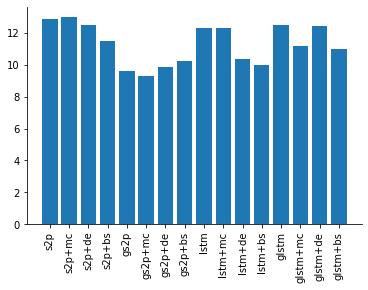

In [19]:
plt.bar(metric['approach'],metric['Te_mae'])
# plt.bar(metric['approach'],metric['Te_l1_ce'])
plt.xticks(rotation=90)
sns.despine()

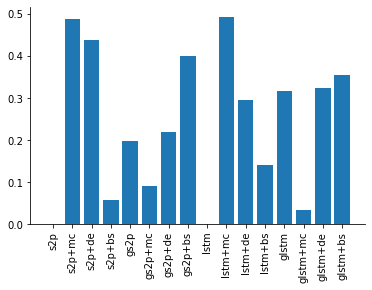

In [20]:
plt.bar(metric['approach'],metric['Te_ce'])
plt.xticks(rotation=90)
sns.despine()

MAE = s2p_gmlp_testing mc \
TRADEOFF = lstm_mlp_testing bs \
ECE = lstm_gmlp_testing mc

In [21]:
idx1=4750
idx2=5000

In [22]:
timestamp = s2p_gmlp_testing["timestamp"][idx1:idx2]

In [23]:
timestamp = pd.to_datetime(timestamp).dt.strftime('%H:%M')

In [34]:
def plot_figure(ax, y, mean, sigma, title):
    ax.plot(timestamp, y[idx1:idx2], label="Y")
    ax.plot(timestamp, mean[idx1:idx2], label="Mean")
    ax.plot(timestamp, sigma[idx1:idx2], label="Sigma")
    ax.set_xticks(jnp.arange(0, idx2-idx1, 30), fontsize=2)
    ax.tick_params(axis='x',rotation=60)
    error = errors.mae(y.values, mean.values)
    df = recalibration.find_p_hat(y, mean, sigma)
    df=df.reset_index()
    ax.set_title(f'{title} \nMAE = {error:.2f}, ECE = {mae_(df):.2f}\n')


In [39]:
def plot_callibration(ax, y, mean, sigma):
    off_idx = y <= 200
    on_idx = y > 200
    off_truth, off_mean, off_sigma = y[off_idx], mean[off_idx], sigma[off_idx]
    on_truth, on_mean, on_sigma = y[on_idx], mean[on_idx], sigma[on_idx]

    df = recalibration.find_p_hat(y, mean, sigma)
    df=df.reset_index()
    ax.plot(df["p"], df["p_hat"], "--", label="Total")
    total_error = mae_(df)

    df = recalibration.find_p_hat(off_truth,  off_mean, off_sigma)
    df=df.reset_index()
    ax.plot(df["p"], df["p_hat"], "--", label="Off")
    off_error = mae_(df)

    df = recalibration.find_p_hat(on_truth,  on_mean, on_sigma)
    df=df.reset_index()
    ax.plot(df["p"], df["p_hat"], "--", label="On")
    on_error = mae_(df)

    ax.plot([0,1],[0,1], "--", color="black", label="Ideal")
    ax.set_title(f'\nOn ECE = {on_error:.4f}\nOff ECE = {off_error:.4f}')

In [40]:
latexify(fig_width=6.6, fig_height=4)

/tmp/ipykernel_779/1669252933.py:5: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks(jnp.arange(0, idx2-idx1, 30), fontsize=2)
/tmp/ipykernel_779/1669252933.py:5: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks(jnp.arange(0, idx2-idx1, 30), fontsize=2)
/tmp/ipykernel_779/1669252933.py:5: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks(jnp.arange(0, idx2-idx1, 30), fontsize=2)


saving image to figures/best_error_dishwasher_latexified.pdf
Figure size: [6.6 4. ]


<Figure size 475.2x288 with 0 Axes>

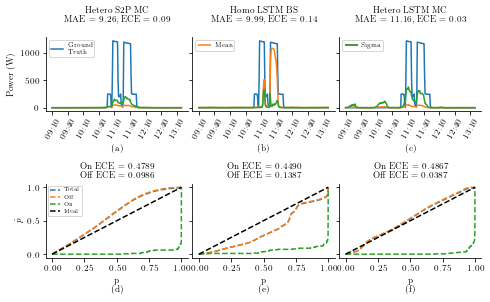

In [41]:
plt.figure()
fig, ax = plt.subplots(2, 3, sharey="row")

plot_figure(ax[0,0], s2p_gmlp_testing["ground truth"], s2p_gmlp_testing["mc_mean"], 
            s2p_gmlp_testing["mc_sigma"], "Hetero S2P MC")
plot_figure(ax[0,1], lstm_mlp_testing["ground truth"], lstm_mlp_testing["bs_mean"], 
            lstm_mlp_testing["bs_sigma"], "Homo LSTM BS")
plot_figure(ax[0,2], lstm_gmlp_testing["ground truth"], lstm_gmlp_testing["mc_mean"], 
            lstm_gmlp_testing["mc_sigma"], "Hetero LSTM MC")

plot_callibration(ax[1,0], s2p_gmlp_testing["ground truth"], s2p_gmlp_testing["mc_mean"], 
                  s2p_gmlp_testing["mc_sigma"])
plot_callibration(ax[1,1], lstm_mlp_testing["ground truth"], lstm_mlp_testing["bs_mean"], 
                  lstm_mlp_testing["bs_sigma"])
plot_callibration(ax[1,2], lstm_gmlp_testing["ground truth"], lstm_gmlp_testing["mc_mean"], 
                  lstm_gmlp_testing["mc_sigma"])

ax[0,0].legend(["Ground\nTruth"], loc="upper left", fontsize=6)
line = mlines.Line2D([], [], color='C1', marker="_", ls='', label='Mean', markersize=13,
                    markeredgewidth=1.5)
ax[0,1].legend(handles=[line], loc="upper left", fontsize=6)
line = mlines.Line2D([], [], color='green', marker="_", ls='', label='Sigma', markersize=13,
                    markeredgewidth=1.5)
ax[0,2].legend(handles=[line], loc="upper left", fontsize=6)

ax[0,0].set_xlabel("(a)")
ax[0,1].set_xlabel("(b)")
ax[0,2].set_xlabel("(c)")
ax[1,0].set_xlabel("p\n(d)")
ax[1,1].set_xlabel("p\n(e)")
ax[1,2].set_xlabel("p\n(f)")

ax[1,0].legend(fontsize=5, loc="upper left")
ax[0,0].set_ylabel("Power (W)")
ax[1,0].set_ylabel("$\hat{p}$")
sns.despine()
savefig("best_error_dishwasher")